# Modeling

In [1]:
# load libraries

import numpy as np
import pandas as pd
import geopandas as gpd

from matplotlib import pyplot as plt
%matplotlib inline
import altair as alt

from sklearn.cluster import KMeans, dbscan 
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
plt.rcParams['figure.figsize'] = (10,6)

alt.renderers.enable("notebook")
np.random.seed(42)

In [3]:
path_data = './data/data_101219.geojson'

data = gpd.read_file(path_data)

### Aqueduct attributes for clustering

Baseline water stress: bws_raw  
Baseline water depletion: bwd_raw  
Interannual variability: iav_raw  
Seasonal variability: sev_raw  
Groundwater table decline: gtd_raw  
Riverine flood risk: rfr_raw  
Coastal flood risk: cfr_raw  
Drought risk: drr_raw  
Untreated connected wastewater: ucw_raw  
Unimproved/no drinking water: udw_raw  
Unimproved/no sanitation: usa_raw  

In [4]:
pd.set_option('display.max_columns', None)
data.head(1)

,string_id,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,geometry
0,111011-EGY.11_1-3365,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,0.6139,0.01057,0.023176,34.693151,2.522154,0.0,(POLYGON ((31.90590570688292 29.85788702426048...


# Create Pipeline

1. Imputation option for missing data: https://scikit-learn.org/stable/modules/impute.html
1. Standard scaler
1. kmeans
1. optimize K using elbow method: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
1. generate final clusters
1. join clusters back to original data (unscaled)
1. summarise means for each group
1. describe group typologies

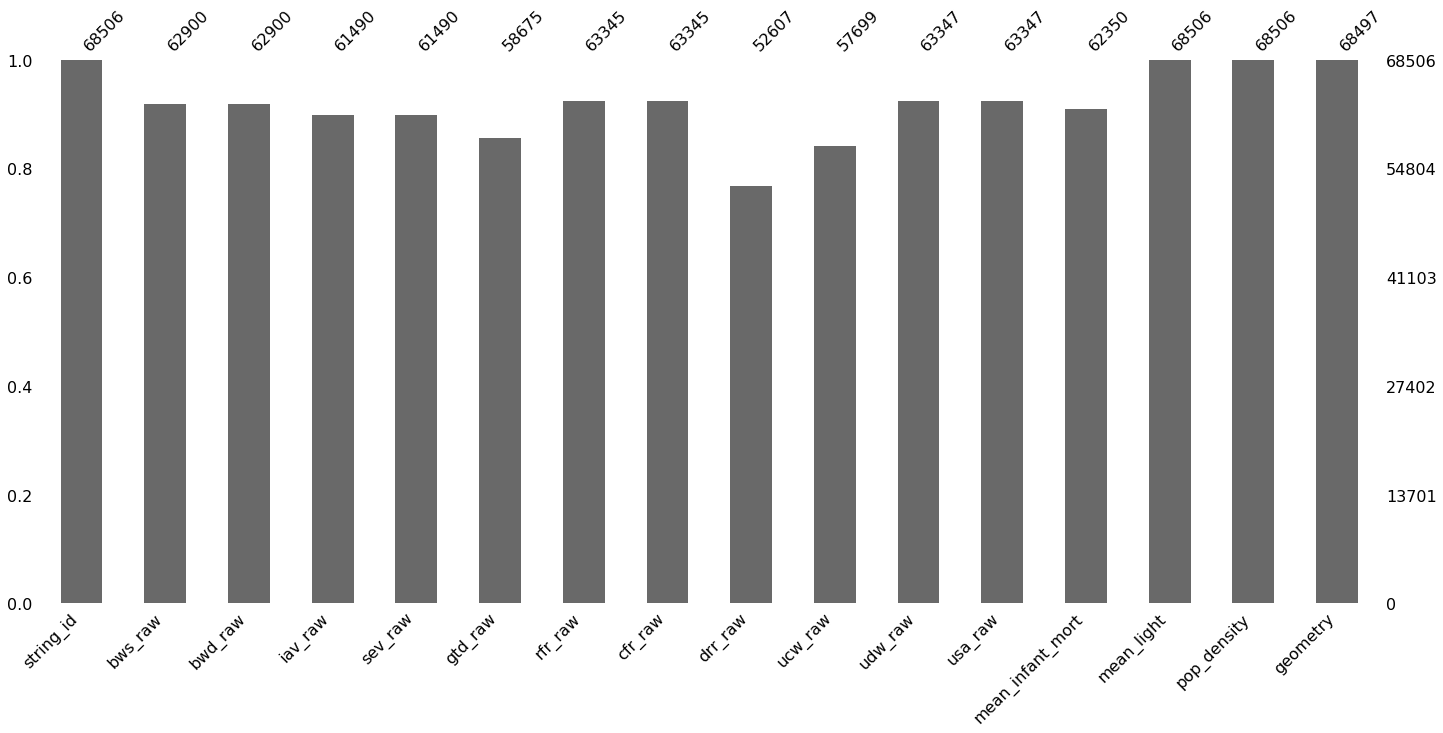

In [6]:
import missingno as msno
msno.bar(data)

## Dropping all NA Values

In [7]:
data = data.dropna()
data.shape

## Physical Risk Variables cluster

In [9]:
physical_risk_cols = ['ucw_raw', 'udw_raw', 'usa_raw', 'mean_infant_mort', 'mean_light', 'pop_density']
physical_risk = data[physical_risk_cols].copy()
physical_risk.head()

,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density
89,-1.0,0.217479,0.708491,33.800000,0.000000,0.000000
90,-1.0,0.217479,0.708491,44.714826,0.081541,0.000000
92,-1.0,0.217479,0.708491,39.015000,0.188762,208.386554
93,-1.0,0.217479,0.708491,39.015000,0.246018,189.688560
94,-1.0,0.217479,0.708491,39.038256,0.097656,75.549332


In [10]:
scaler = StandardScaler()

In [11]:
physical_risk_scaled = scaler.fit_transform(physical_risk)
physical_risk_scaled

array([[-2.27507023,  0.61472883,  1.70667864,  0.51062163, -0.37581312,
        -0.18402743],
       [-2.27507023,  0.61472883,  1.70667864,  0.98140357, -0.36407751,
        -0.18402743],
       [-2.27507023,  0.61472883,  1.70667864,  0.73555677, -0.34864604,
        -0.14850247],
       ...,
       [-0.39232361, -0.7299447 , -0.92537345, -0.72485026, -0.37079218,
        -0.18402743],
       [-0.39232361, -0.7299447 , -0.92537345, -0.70867563, -0.36731886,
        -0.18402743],
       [-0.39232361, -0.7299447 , -0.92537345, -0.08190885, -0.36547176,
        -0.18402743]])

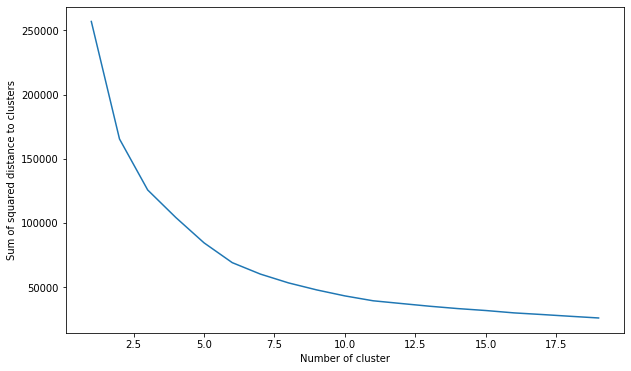

In [12]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(physical_risk_scaled)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Sum of squared distance to clusters")
plt.show()

In [13]:
kmeans = KMeans(n_clusters = 10)
kmeans.fit(physical_risk_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [14]:
data['PR_labels'] = kmeans.labels_
data.head(1)

,string_id,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,geometry,PR_labels
89,111081-ERI.2_1-3365,0.126168,0.038672,0.513708,1.269381,0.843958,0.102012,0.0,2.21514,-1.0,0.217479,0.708491,33.8,0.0,0.0,(POLYGON ((38.02511783242218 17.54865928955046...,3


In [15]:
data.groupby('PR_labels').size()

PR_labels
0    11683
1     2182
2      133
3     3673
4      656
5    16469
6     1937
7       22
8     3894
9     2174
dtype: int64

## Depletion Variables cluster

In [16]:
depletion_cols = ['bws_raw', 'bwd_raw', 'iav_raw', 'sev_raw', 'gtd_raw', 'mean_infant_mort', 'mean_light', 'pop_density']
depletion_risk = data[depletion_cols].copy()
depletion_risk.head()

,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,mean_infant_mort,mean_light,pop_density
89,0.126168,0.038672,0.513708,1.269381,0.843958,33.800000,0.000000,0.000000
90,0.126168,0.038672,0.513708,1.269381,0.843958,44.714826,0.081541,0.000000
92,0.126168,0.038672,0.513708,1.269381,0.162628,39.015000,0.188762,208.386554
93,0.126168,0.038672,0.513708,1.269381,0.063822,39.015000,0.246018,189.688560
94,0.126168,0.038672,0.513708,1.269381,0.843958,39.038256,0.097656,75.549332


In [17]:
depletion_scaled = scaler.fit_transform(depletion_risk)
depletion_scaled

array([[-0.00400102, -0.01858037,  0.04985714, ...,  0.51062163,
        -0.37581312, -0.18402743],
       [-0.00400102, -0.01858037,  0.04985714, ...,  0.98140357,
        -0.36407751, -0.18402743],
       [-0.00400102, -0.01858037,  0.04985714, ...,  0.73555677,
        -0.34864604, -0.14850247],
       ...,
       [-0.01042389, -0.02506317,  0.12903412, ..., -0.72485026,
        -0.37079218, -0.18402743],
       [-0.01042389, -0.02506317,  0.12903412, ..., -0.70867563,
        -0.36731886, -0.18402743],
       [-0.01042389, -0.02506317,  0.12903412, ..., -0.08190885,
        -0.36547176, -0.18402743]])

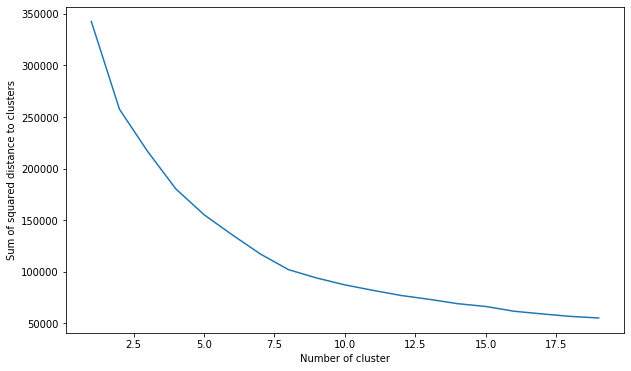

In [18]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(depletion_scaled)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Sum of squared distance to clusters")
plt.show()

In [19]:
kmeans = KMeans(n_clusters = 10)
kmeans.fit(depletion_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [20]:
data['deplete_labels'] = kmeans.labels_
data.head(1)

,string_id,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,geometry,PR_labels,deplete_labels
89,111081-ERI.2_1-3365,0.126168,0.038672,0.513708,1.269381,0.843958,0.102012,0.0,2.21514,-1.0,0.217479,0.708491,33.8,0.0,0.0,(POLYGON ((38.02511783242218 17.54865928955046...,3,5


In [21]:
data.groupby('deplete_labels').size()

deplete_labels
0     5633
1    17537
2        1
3     1746
4     2252
5    13062
6     1991
7       51
8      408
9      142
dtype: int64

## Flood/Drought variables cluster

In [22]:
floodrought_cols = ['rfr_raw', 'cfr_raw', 'drr_raw', 'mean_infant_mort', 'mean_light', 'pop_density']
floodrought_risk = data[floodrought_cols].copy()
floodrought_risk.head()

,rfr_raw,cfr_raw,drr_raw,mean_infant_mort,mean_light,pop_density
89,0.102012,0.0,2.21514,33.800000,0.000000,0.000000
90,0.102012,0.0,2.21514,44.714826,0.081541,0.000000
92,0.102012,0.0,2.21514,39.015000,0.188762,208.386554
93,0.102012,0.0,2.21514,39.015000,0.246018,189.688560
94,0.102012,0.0,2.21514,39.038256,0.097656,75.549332


In [23]:
floodrought_scaled = scaler.fit_transform(floodrought_risk)
floodrought_scaled

array([[ 5.62070665, -0.0620456 , -0.09433314,  0.51062163, -0.37581312,
        -0.18402743],
       [ 5.62070665, -0.0620456 , -0.09433314,  0.98140357, -0.36407751,
        -0.18402743],
       [ 5.62070665, -0.0620456 , -0.09433314,  0.73555677, -0.34864604,
        -0.14850247],
       ...,
       [-0.534529  , -0.0620456 , -0.86462922, -0.72485026, -0.37079218,
        -0.18402743],
       [-0.534529  , -0.0620456 , -0.86462922, -0.70867563, -0.36731886,
        -0.18402743],
       [-0.534529  , -0.0620456 , -0.86462922, -0.08190885, -0.36547176,
        -0.18402743]])

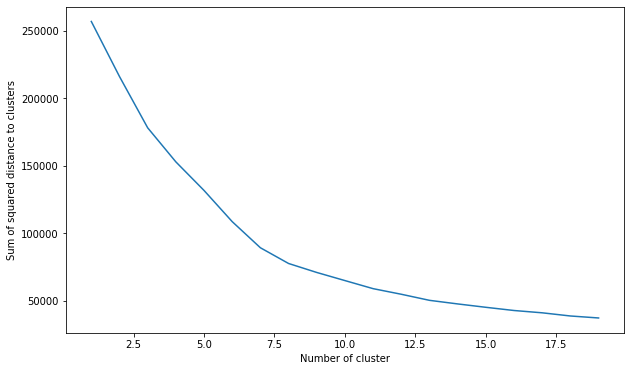

In [24]:
sse = {}
for k in range(1, 20):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(floodrought_scaled)
    sse[k] = kmeans.inertia_
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Sum of squared distance to clusters")
plt.show()

In [25]:
kmeans = KMeans(n_clusters = 10)
kmeans.fit(floodrought_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [26]:
data['floodrought_labels'] = kmeans.labels_
data.head(1)

,string_id,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density,geometry,PR_labels,deplete_labels,floodrought_labels
89,111081-ERI.2_1-3365,0.126168,0.038672,0.513708,1.269381,0.843958,0.102012,0.0,2.21514,-1.0,0.217479,0.708491,33.8,0.0,0.0,(POLYGON ((38.02511783242218 17.54865928955046...,3,5,2


In [27]:
data.groupby('floodrought_labels').size()

floodrought_labels
0     1479
1    14270
2      524
3     2651
4     6301
5        5
6       24
7    17312
8       69
9      188
dtype: int64

In [31]:
data.to_file("./data/data_with_labels.geojson", driver='GeoJSON')

## Quick Viz

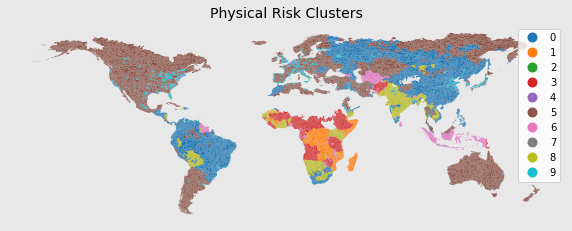

In [28]:
fig, ax = plt.subplots(figsize=(10,10), facecolor='#E8E8E8')
data.plot(ax = ax, column = 'PR_labels', legend=True, categorical = True)
ax.set_title("Physical Risk Clusters", fontsize=14)
ax.set_axis_off()

In [29]:
pr_cluster_means = data.groupby(['PR_labels'])['ucw_raw', 'udw_raw', 'usa_raw', 'mean_infant_mort', 'mean_light', 'pop_density'].mean()
pr_cluster_means.reset_index()
pr_cluster_means

,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density
PR_labels,,,,,,
0,0.881983,0.090116,0.280706,14.987156,1.089655,545.959972
1,0.998425,0.541859,0.765965,66.307670,0.676860,364.196566
2,0.481350,0.074075,0.181574,19.990427,50.242982,60243.400576
3,-0.999436,0.409206,0.723054,64.057287,0.703394,676.975636
4,0.421953,0.025856,0.069591,8.855447,40.885702,11087.909502
5,0.498003,0.015951,0.020980,7.907273,1.219217,172.249076
6,-1.000000,0.107604,0.209651,28.394900,1.188287,922.604698
7,0.378615,0.096508,0.226265,22.110852,56.848184,174542.207290
8,0.970655,0.194540,0.529078,44.243521,1.140001,1507.683838


In [30]:
pr_cluster_medians = data.groupby(['PR_labels'])['ucw_raw', 'udw_raw', 'usa_raw', 'mean_infant_mort', 'mean_light', 'pop_density'].median()
pr_cluster_medians

,ucw_raw,udw_raw,usa_raw,mean_infant_mort,mean_light,pop_density
PR_labels,,,,,,
0,0.926190,0.082243,0.277389,13.545556,0.356046,57.278199
1,1.000000,0.531647,0.752337,67.553919,0.474570,75.145417
2,0.926976,0.033755,0.107948,12.100000,55.031100,54968.775351
3,-1.000000,0.405710,0.719847,62.677768,0.357502,123.469453
4,0.310000,0.012620,0.006317,5.798262,38.426819,8331.309923
5,0.488816,0.005130,0.001175,6.444330,0.250859,6.692330
6,-1.000000,0.111931,0.249161,25.039446,0.200779,93.590790
7,0.722500,0.054175,0.165447,15.795746,61.988437,167148.141939
8,1.000000,0.198699,0.555612,40.987323,0.351533,202.043261


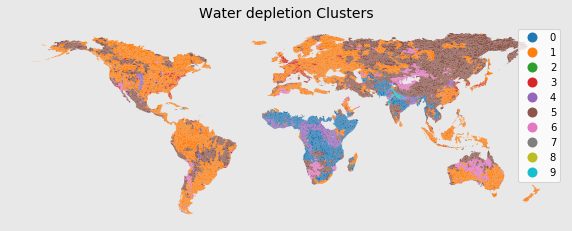

In [31]:
fig, ax = plt.subplots(figsize=(10,10), facecolor='#E8E8E8')
data.plot(ax = ax, column = 'deplete_labels', legend=True, categorical = True)
ax.set_title("Water depletion Clusters", fontsize=14)
ax.set_axis_off()

In [32]:
deplete_means = data.groupby(['deplete_labels'])['bws_raw', 'bwd_raw', 'iav_raw', 'sev_raw', 'gtd_raw', 'mean_infant_mort', 'mean_light', 'pop_density'].mean()
deplete_means.reset_index()
deplete_means

,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,mean_infant_mort,mean_light,pop_density
deplete_labels,,,,,,,,
0,0.264226,0.189016,0.404839,0.839430,-0.255646,66.546253,0.828626,733.196491
1,0.176884,0.099533,0.419844,0.391405,-0.026861,11.194062,1.571622,368.681067
2,-4055.908161,-1229.884302,0.745612,0.825394,0.030899,86.120270,0.090331,364.734468
3,0.351965,0.133955,0.383946,0.518535,0.191828,8.983224,21.345759,4409.272309
4,0.211727,0.119888,0.310138,0.590095,2.395494,49.502872,1.367495,1836.526554
5,0.389149,0.215739,0.481815,0.933627,0.011709,14.856355,1.120247,449.809374
6,0.871963,0.690529,1.809372,0.958108,-0.100387,18.490729,0.428843,101.526720
7,0.294082,0.113175,0.367596,0.581136,0.675366,22.369281,55.547864,127581.999757
8,0.273358,0.108475,0.372338,0.537395,0.302232,12.360967,48.206399,24899.455193


In [33]:
deplete_medians = data.groupby(['deplete_labels'])['bws_raw', 'bwd_raw', 'iav_raw', 'sev_raw', 'gtd_raw', 'mean_infant_mort', 'mean_light', 'pop_density'].median()
deplete_medians.reset_index()
deplete_medians

,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,mean_infant_mort,mean_light,pop_density
deplete_labels,,,,,,,,
0,0.036234,0.022854,0.365954,0.804855,-0.000287,63.366370,0.451358,136.310889
1,0.023819,0.008340,0.364115,0.388131,0.000000,8.376253,0.416483,47.991438
2,-4055.908161,-1229.884302,0.745612,0.825394,0.030899,86.120270,0.090331,364.734468
3,0.145950,0.048949,0.346466,0.472669,0.039884,6.023196,19.286179,3058.654689
4,0.006953,0.004185,0.227356,0.560764,2.278350,46.226443,0.549878,267.063157
5,0.128281,0.071102,0.434045,0.889015,0.030899,11.200000,0.249900,20.157477
6,1.000000,0.836283,1.566767,0.985645,-0.019567,17.050000,0.097852,0.186187
7,0.066196,0.021945,0.338293,0.530924,0.032887,12.449443,61.986742,104863.964777
8,0.082729,0.032567,0.332071,0.499914,0.104340,6.984320,49.272847,19279.247683


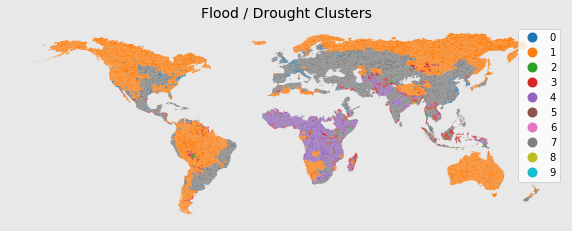

In [34]:
fig, ax = plt.subplots(figsize=(10,10), facecolor='#E8E8E8')
data.plot(ax = ax, column = 'floodrought_labels', legend=True, categorical = True)
ax.set_title("Flood / Drought Clusters", fontsize=14)
ax.set_axis_off()